In [55]:
%pwd

'/cephfs/volumes/hpc_data_usr/k24083007/2070c87e-fe07-4f03-a6c4-cae0de8ce617/cmu-mosei-experiments'

In [56]:
%cd cmu-mosei-experiments/

[Errno 2] No such file or directory: 'cmu-mosei-experiments/'
/cephfs/volumes/hpc_data_usr/k24083007/2070c87e-fe07-4f03-a6c4-cae0de8ce617/cmu-mosei-experiments


In [57]:
!nvidia-smi

Fri Aug  1 09:15:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:00:07.0 Off |                    0 |
| N/A   32C    P0              43W / 300W |      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [58]:
import pickle
import torch
from collections import defaultdict
import os

In [14]:
# Directory where our OMGEmotion .csd files are saved
CSD_DIR = 'omg_features_csd'

splits = ['train', 'val', 'test']
modalities = ['AUDIO', 'VISUAL', 'TEXT', 'LABELS']

# Map to your actual file naming
csd_files = {
    split: {
        'AUDIO': f'OMG_{split.upper()}_AUDIO.csd',
        'VISUAL': f'OMG_{split.upper()}_VISUAL.csd',
        'TEXT': f'OMG_{split.upper()}_TEXT.csd',
        'LABELS': f'OMG_{split.upper()}_LABELS.csd'
    }
    for split in splits
}

In [15]:
omg_pt_data = {split: defaultdict(list) for split in splits}

In [16]:
import numpy as np

def process_omg_labels_multitask(label_arr):
    """
    Process OMGEmotion labels for multi-task learning with CARAT:
    - Convert 7 emotions to 6 emotions (remove Neutral) 
    - Separate valence and arousal as independent targets
    
    Original OMGEmotion: [discrete emotion, valence, arousal]
    OMGEmotion 7 emotions: [Anger, Disgust, Fear, Happy, Neutral, Sad, Surprise]
    
    Technical reasoning for removing Neutral:
    1. Neutral represents absence of emotion, not an emotion itself
    2. Can be captured by valence≈0 and arousal≈0 
    3. Aligns with CMU-MOSEI's 6-emotion framework
    4. Dimensional emotion theory treats neutral as center point
    
    Output: 6-emotion one-hot, valence scalar, arousal scalar
    """
    arr = np.array(label_arr).flatten()
    discrete = arr[0]
    valence = arr[1] 
    arousal = arr[2]
    
    # Convert discrete emotion to one-hot (7 classes first)
    discrete_int = int(round(discrete))
    one_hot_7 = np.zeros(7, dtype=np.float32)
    if 0 <= discrete_int < 7:
        one_hot_7[discrete_int] = 1.0
    
    # Convert 7 emotions to 6 emotions by removing Neutral (index 4)
    # Original: [Anger=0, Disgust=1, Fear=2, Happy=3, Neutral=4, Sad=5, Surprise=6]
    # New 6:    [Anger=0, Disgust=1, Fear=2, Happy=3, Sad=4, Surprise=5]
    
    if discrete_int == 4:  # If original emotion was Neutral
        # Handle neutral case: could map to low valence/arousal or create "no emotion" vector
        # Option 1: Map to zero vector (no dominant emotion)
        emotions_6 = np.zeros(6, dtype=np.float32)
        print(f"  Neutral emotion detected, mapped to zero vector")
    elif discrete_int > 4:  # Sad=5 or Surprise=6 in original
        # Shift indices down by 1 (Sad becomes 4, Surprise becomes 5)
        emotions_6 = np.zeros(6, dtype=np.float32)
        emotions_6[discrete_int - 1] = 1.0
    else:  # Anger=0, Disgust=1, Fear=2, Happy=3
        # Keep same indices
        emotions_6 = np.zeros(6, dtype=np.float32)
        emotions_6[discrete_int] = 1.0
    
    return emotions_6, valence, arousal

# Track processing statistics with more detail
processing_stats = {split: {
    'total': 0, 'processed': 0, 'errors': 0, 
    'neutral_count': 0, 'emotion_distribution': np.zeros(6)
} for split in splits}

# Emotion names for the new 6-class system
emotion_names_6 = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']
emotion_names_7_original = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

print("="*70)
print("CREATING MULTI-TASK OMGEmotion DATASET FOR CARAT")
print("="*70)
print("Conversion: 7 emotions → 6 emotions + valence + arousal")
print("Removing: Neutral emotion (mapped to zero vector)")
print("New 6 emotions:", emotion_names_6)
print("="*70)

for split in splits:
    print("-" * 40)
    print(f'Processing split: {split}')
    
    # Load all modalities for this split
    data = {}
    for mod in modalities:
        path = os.path.join(CSD_DIR, csd_files[split][mod])
        with open(path, 'rb') as f:
            data[mod] = pickle.load(f)

    # Count total segments in this split
    audio_keys = set(data['AUDIO'].keys())
    visual_keys = set(data['VISUAL'].keys())
    text_keys = set(data['TEXT'].keys())
    label_keys = set(data['LABELS'].keys())
    
    # Find common segments across all modalities
    common_keys = audio_keys & visual_keys & text_keys & label_keys
    processing_stats[split]['total'] = len(audio_keys)
    
    print(f"  Audio segments: {len(audio_keys)}")
    print(f"  Visual segments: {len(visual_keys)}")
    print(f"  Text segments: {len(text_keys)}")
    print(f"  Label segments: {len(label_keys)}")
    print(f"  Common segments: {len(common_keys)}")

    # For each segment, collect features
    for seg in common_keys:
        try:
            # All modalities should have the same keys
            audio = data['AUDIO'][seg]['features']
            visual = data['VISUAL'][seg]['features']
            text = data['TEXT'][seg]['features']
            label = data['LABELS'][seg]['features']
            
            # Process labels: convert to 6 emotions + separate valence/arousal
            emotions_6, valence, arousal = process_omg_labels_multitask(label)
            
            # Track emotion distribution
            emotion_idx = np.argmax(emotions_6) if emotions_6.sum() > 0 else -1
            if emotion_idx >= 0:
                processing_stats[split]['emotion_distribution'][emotion_idx] += 1
            else:
                processing_stats[split]['neutral_count'] += 1
            
            # Store in CARAT multi-task format
            omg_pt_data[split]['src-audio'].append(audio)
            omg_pt_data[split]['src-visual'].append(visual)
            omg_pt_data[split]['src-text'].append(text)
            omg_pt_data[split]['tgt'].append(emotions_6)  # 6 emotions for classification
            omg_pt_data[split]['valence'].append(valence)  # Valence for regression
            omg_pt_data[split]['arousal'].append(arousal)   # Arousal for regression
            
            processing_stats[split]['processed'] += 1
            
        except Exception as e:
            print(f"  Error processing segment {seg}: {e}")
            processing_stats[split]['errors'] += 1
            
    print(f"  Successfully processed: {processing_stats[split]['processed']}")
    print(f"  Neutral emotions mapped: {processing_stats[split]['neutral_count']}")
    print(f"  Errors: {processing_stats[split]['errors']}")

print("\n" + "="*50)
print("PROCESSING SUMMARY:")
for split in splits:
    stats = processing_stats[split]
    print(f"{split.upper()}: {stats['processed']}/{stats['total']} segments processed")
    print(f"  Errors: {stats['errors']}, Neutral→Zero: {stats['neutral_count']}")
    print(f"  Emotion distribution:")
    for i, emotion in enumerate(emotion_names_6):
        count = int(stats['emotion_distribution'][i])
        pct = (count / stats['processed']) * 100 if stats['processed'] > 0 else 0
        print(f"    {emotion}: {count} ({pct:.1f}%)")
    print("")

print("="*50) 
print("DATASET FORMAT FOR MULTI-TASK CARAT:")
print("- Emotions: 6-class one-hot vectors")
print("- Valence: Continuous regression target") 
print("- Arousal: Continuous regression target")

CREATING MULTI-TASK OMGEmotion DATASET FOR CARAT
Conversion: 7 emotions → 6 emotions + valence + arousal
Removing: Neutral emotion (mapped to zero vector)
New 6 emotions: ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']
----------------------------------------
Processing split: train
  Audio segments: 691
  Visual segments: 691
  Text segments: 691
  Label segments: 691
  Common segments: 691
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vector
  Neutral emotion detected, mapped to zero vec

In [17]:
print("\n--------- Multi-Task OMGEmotion Data Structure -------------")
print("Format: 6 emotions + separate valence + separate arousal")
print(f"Train segments: {len(omg_pt_data['train']['src-text'])}")
print(f"Validation segments: {len(omg_pt_data['val']['src-text'])}")
print(f"Test segments: {len(omg_pt_data['test']['src-text'])}")

# Check that all targets have same length
train_data = omg_pt_data['train']
print(f"\nData integrity check:")
print(f"  Text samples: {len(train_data['src-text'])}")
print(f"  Audio samples: {len(train_data['src-audio'])}")
print(f"  Visual samples: {len(train_data['src-visual'])}")
print(f"  Emotion targets: {len(train_data['tgt'])}")
print(f"  Valence targets: {len(train_data['valence'])}")
print(f"  Arousal targets: {len(train_data['arousal'])}")

print(f"-"*50)
print("Sample data shapes (first 3 train segments):")
emotion_names_6 = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

for i in range(3):
    text = train_data['src-text'][i]
    audio = train_data['src-audio'][i]
    visual = train_data['src-visual'][i]
    emotion = train_data['tgt'][i]
    valence = train_data['valence'][i]
    arousal = train_data['arousal'][i]
    
    print(f"\nSegment {i+1}:")
    print(f"  Text shape: {text.shape}")
    print(f"  Audio shape: {audio.shape}")  
    print(f"  Visual shape: {visual.shape}")
    print(f"  Emotion shape: {emotion.shape} (6-class one-hot)")
    print(f"  Emotion: {emotion_names_6[np.argmax(emotion)]} (confidence: {np.max(emotion):.3f})")
    print(f"  Valence: {valence:.3f}")
    print(f"  Arousal: {arousal:.3f}")

print(f"\n" + "="*50)
print("MULTI-TASK TARGET SUMMARY:")
print("1. Emotion Classification: 6 classes (one-hot)")
print("="*50)


--------- Multi-Task OMGEmotion Data Structure -------------
Format: 6 emotions + separate valence + separate arousal
Train segments: 691
Validation segments: 121
Test segments: 1027

Data integrity check:
  Text samples: 691
  Audio samples: 691
  Visual samples: 691
  Emotion targets: 691
  Valence targets: 691
  Arousal targets: 691
--------------------------------------------------
Sample data shapes (first 3 train segments):

Segment 1:
  Text shape: (1, 50)
  Audio shape: (48, 74)
  Visual shape: (812, 136)
  Emotion shape: (6,) (6-class one-hot)
  Emotion: Disgust (confidence: 1.000)
  Valence: -0.216
  Arousal: 0.509

Segment 2:
  Text shape: (1, 50)
  Audio shape: (48, 74)
  Visual shape: (1211, 136)
  Emotion shape: (6,) (6-class one-hot)
  Emotion: Sad (confidence: 1.000)
  Valence: -0.380
  Arousal: 0.463

Segment 3:
  Text shape: (1, 50)
  Audio shape: (48, 74)
  Visual shape: (364, 136)
  Emotion shape: (6,) (6-class one-hot)
  Emotion: Anger (confidence: 0.000)
  Valenc

In [18]:
# Save multi-task OMGEmotion dataset for CARAT
output_path = 'CARAT/data/omg_multitask.pt'
torch.save(omg_pt_data, output_path)

print(f"Multi-task OMGEmotion dataset saved to: {output_path}")
print("\nDataset structure:")
print("- 6 emotion classes (removed Neutral)")
print("- Separate valence regression target")  
print("- Separate arousal regression target")
print("\nReady for multi-task CARAT training!")

# Also save data summary for reference
import json
summary = {
    'format': 'multi-task',
    'emotions': 6,
    'emotion_names': ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise'],
    'targets': ['emotions', 'valence', 'arousal'],
    'splits': {split: len(omg_pt_data[split]['src-text']) for split in ['train', 'val', 'test']},
    'removed_emotion': 'Neutral',
    'reasoning': 'Neutral mapped to zero vector as it represents absence of emotion'
}

with open('CARAT/data/omg_multitask_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\nDataset summary saved to: CARAT/data/omg_multitask_summary.json")

Multi-task OMGEmotion dataset saved to: CARAT/data/omg_multitask.pt

Dataset structure:
- 6 emotion classes (removed Neutral)
- Separate valence regression target
- Separate arousal regression target

Ready for multi-task CARAT training!

Dataset summary saved to: CARAT/data/omg_multitask_summary.json


In [19]:
import os
import sys
import torch
import numpy as np

# Path to the multi-task OMGEmotion dataset
omg_data_path = 'CARAT/data/omg_multitask.pt'
print(f"Multi-task dataset file exists: {os.path.exists(omg_data_path)}")

if os.path.exists(omg_data_path):
    print(f"File size: {os.path.getsize(omg_data_path) / (1024*1024):.2f} MB")

try:
    omg_data = torch.load(omg_data_path, map_location='cpu')
    print("Multi-task dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    sys.exit(1)

print(f"\nTop-level keys: {list(omg_data.keys())}")
if 'train' in omg_data:
    print(f"Train data keys: {list(omg_data['train'].keys())}")

# Check expected keys for multi-task format
expected_keys = ['src-text', 'src-visual', 'src-audio', 'tgt', 'valence', 'arousal']
for split in ['train', 'val', 'test']:
    if split in omg_data:
        split_data = omg_data[split]
        print(f"\n{split.upper()} split:")
        for key in expected_keys:
            if key not in split_data:
                print(f"  Missing key '{key}'")
            else:
                count = len(split_data[key])
                print(f"  Key '{key}': {count} items")
        
        # Validate data consistency
        lengths = [len(split_data[key]) for key in expected_keys if key in split_data]
        if len(set(lengths)) == 1:
            print(f"  All data arrays have consistent length: {lengths[0]}")
        else:
            print(f"  Inconsistent data lengths: {lengths}")

# Validate multi-task target format
print(f"\n" + "="*50)
print("MULTI-TASK TARGET VALIDATION:")
train_data = omg_data['train']
emotion_names_6 = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

print(f"Sample count: {len(train_data['tgt'])}")
print(f"Emotion target shape: {train_data['tgt'][0].shape} (should be (6,))")
print(f"Valence target type: {type(train_data['valence'][0])} (should be float)")
print(f"Arousal target type: {type(train_data['arousal'][0])} (should be float)")

# Check emotion distribution
all_emotions = np.array(train_data['tgt'])
emotion_counts = np.sum(all_emotions, axis=0)
total_samples = len(all_emotions)

print(f"\nEmotion distribution in train split:")
for i, emotion in enumerate(emotion_names_6):
    count = int(emotion_counts[i])
    percentage = (count / total_samples) * 100
    print(f"  {emotion}: {count} samples ({percentage:.1f}%)")

# Check for zero vectors (neutral emotions)
zero_vectors = np.sum(all_emotions.sum(axis=1) == 0)
print(f"\nZero emotion vectors (mapped neutrals): {zero_vectors} ({zero_vectors/total_samples*100:.1f}%)")

# Validate value ranges
all_valences = np.array(train_data['valence'])
all_arousals = np.array(train_data['arousal'])

print(f"\nValue ranges:")
print(f"  Valence: [{np.min(all_valences):.3f}, {np.max(all_valences):.3f}]")
print(f"  Arousal: [{np.min(all_arousals):.3f}, {np.max(all_arousals):.3f}]")

Multi-task dataset file exists: True
File size: 101.52 MB
Multi-task dataset loaded successfully!

Top-level keys: ['train', 'val', 'test']
Train data keys: ['src-audio', 'src-visual', 'src-text', 'tgt', 'valence', 'arousal']

TRAIN split:
  Key 'src-text': 691 items
  Key 'src-visual': 691 items
  Key 'src-audio': 691 items
  Key 'tgt': 691 items
  Key 'valence': 691 items
  Key 'arousal': 691 items
  All data arrays have consistent length: 691

VAL split:
  Key 'src-text': 121 items
  Key 'src-visual': 121 items
  Key 'src-audio': 121 items
  Key 'tgt': 121 items
  Key 'valence': 121 items
  Key 'arousal': 121 items
  All data arrays have consistent length: 121

TEST split:
  Key 'src-text': 1027 items
  Key 'src-visual': 1027 items
  Key 'src-audio': 1027 items
  Key 'tgt': 1027 items
  Key 'valence': 1027 items
  Key 'arousal': 1027 items
  All data arrays have consistent length: 1027

MULTI-TASK TARGET VALIDATION:
Sample count: 691
Emotion target shape: (6,) (should be (6,))
Valen

In [20]:
# Final multi-task dataset inspection and CARAT integration guide
import numpy as np

print("="*70)
print("MULTI-TASK OMGEmotion DATASET INSPECTION")
print("="*70)

emotion_names_6 = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

# Show detailed examples
print("\nFirst 5 samples with multi-task targets:")
for i in range(5):
    emotion_vec = omg_data['train']['tgt'][i]
    valence = omg_data['train']['valence'][i]
    arousal = omg_data['train']['arousal'][i]
    
    # Get dominant emotion
    if emotion_vec.sum() > 0:
        emotion_idx = np.argmax(emotion_vec)
        emotion_name = emotion_names_6[emotion_idx]
        confidence = emotion_vec[emotion_idx]
    else:
        emotion_name = "Neutral (Zero Vector)"
        confidence = 0.0
        emotion_idx = -1
    
    print(f"\nSample {i+1}:")
    print(f"  Emotion vector: {emotion_vec}")
    print(f"  Dominant emotion: {emotion_name} (confidence: {confidence:.3f})")
    print(f"  Valence: {valence:.3f}")
    print(f"  Arousal: {arousal:.3f}")

# Dataset statistics
print(f"\n" + "="*50)
print("DATASET STATISTICS:")
for split in ['train', 'val', 'test']:
    data = omg_data[split]
    emotions = np.array(data['tgt'])
    valences = np.array(data['valence'])
    arousals = np.array(data['arousal'])
    
    print(f"\n{split.upper()} Split ({len(emotions)} samples):")
    
    # Emotion distribution
    emotion_counts = np.sum(emotions, axis=0)
    zero_count = np.sum(emotions.sum(axis=1) == 0)
    
    for i, emotion in enumerate(emotion_names_6):
        count = int(emotion_counts[i])
        pct = (count / len(emotions)) * 100
        print(f"  {emotion}: {count} ({pct:.1f}%)")
    print(f"  Neutral (Zero): {zero_count} ({zero_count/len(emotions)*100:.1f}%)")
    
    # Valence/Arousal ranges
    print(f"  Valence: [{np.min(valences):.2f}, {np.max(valences):.2f}] (mean: {np.mean(valences):.2f})")
    print(f"  Arousal: [{np.min(arousals):.2f}, {np.max(arousals):.2f}] (mean: {np.mean(arousals):.2f})")

print(f"\n" + "="*70)

MULTI-TASK OMGEmotion DATASET INSPECTION

First 5 samples with multi-task targets:

Sample 1:
  Emotion vector: [0. 1. 0. 0. 0. 0.]
  Dominant emotion: Disgust (confidence: 1.000)
  Valence: -0.216
  Arousal: 0.509

Sample 2:
  Emotion vector: [0. 0. 0. 0. 1. 0.]
  Dominant emotion: Sad (confidence: 1.000)
  Valence: -0.380
  Arousal: 0.463

Sample 3:
  Emotion vector: [0. 0. 0. 0. 0. 0.]
  Dominant emotion: Neutral (Zero Vector) (confidence: 0.000)
  Valence: 0.486
  Arousal: 0.126

Sample 4:
  Emotion vector: [0. 0. 0. 1. 0. 0.]
  Dominant emotion: Happy (confidence: 1.000)
  Valence: 0.523
  Arousal: 0.301

Sample 5:
  Emotion vector: [0. 0. 0. 0. 1. 0.]
  Dominant emotion: Sad (confidence: 1.000)
  Valence: -0.512
  Arousal: 0.131

DATASET STATISTICS:

TRAIN Split (691 samples):
  Anger: 130 (18.8%)
  Disgust: 49 (7.1%)
  Fear: 13 (1.9%)
  Happy: 180 (26.0%)
  Sad: 117 (16.9%)
  Surprise: 8 (1.2%)
  Neutral (Zero): 194 (28.1%)
  Valence: [-0.82, 0.96] (mean: 0.07)
  Arousal: [0.00,

In [21]:
# Detailed inspection of first three samples
print("="*70)
print("DETAILED SAMPLE INSPECTION - FIRST 3 SAMPLES")
print("="*70)

emotion_names_6 = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

for sample_idx in range(3):
    print(f"\n{'='*20} SAMPLE {sample_idx + 1} {'='*20}")
    
    # Get all modalities for this sample
    text_features = omg_data['train']['src-text'][sample_idx]
    audio_features = omg_data['train']['src-audio'][sample_idx]
    visual_features = omg_data['train']['src-visual'][sample_idx]
    emotion_target = omg_data['train']['tgt'][sample_idx]
    valence_target = omg_data['train']['valence'][sample_idx]
    arousal_target = omg_data['train']['arousal'][sample_idx]
    
    print(f"FEATURE SHAPES:")
    print(f"  Text: {text_features.shape}")
    print(f"  Audio: {audio_features.shape}")
    print(f"  Visual: {visual_features.shape}")
    
    print(f"\nFEATURE DETAILS:")
    print(f"  Text - Min: {text_features.min():.3f}, Max: {text_features.max():.3f}, Mean: {text_features.mean():.3f}")
    print(f"  Audio - Min: {audio_features.min():.3f}, Max: {audio_features.max():.3f}, Mean: {audio_features.mean():.3f}")
    print(f"  Visual - Min: {visual_features.min():.3f}, Max: {visual_features.max():.3f}, Mean: {visual_features.mean():.3f}")
    
    print(f"\nTARGETS:")
    print(f"  Emotion vector: {emotion_target}")
    
    # Determine dominant emotion
    if emotion_target.sum() > 0:
        emotion_idx = np.argmax(emotion_target)
        emotion_name = emotion_names_6[emotion_idx]
        confidence = emotion_target[emotion_idx]
        print(f"  Dominant emotion: {emotion_name} (index: {emotion_idx}, confidence: {confidence:.3f})")
    else:
        print(f"  Dominant emotion: Neutral (Zero Vector)")
    
    print(f"  Valence: {valence_target:.3f}")
    print(f"  Arousal: {arousal_target:.3f}")
    
    # Emotion interpretation
    if valence_target > 0:
        valence_desc = "Positive"
    elif valence_target < 0:
        valence_desc = "Negative"
    else:
        valence_desc = "Neutral"
        
    if arousal_target > 4:
        arousal_desc = "High"
    elif arousal_target < 3:
        arousal_desc = "Low"
    else:
        arousal_desc = "Medium"
        
    print(f"  Interpretation: {valence_desc} valence, {arousal_desc} arousal")

print(f"\n{'='*70}")
print("SAMPLE INSPECTION COMPLETE")
print("="*70)

DETAILED SAMPLE INSPECTION - FIRST 3 SAMPLES

==================== SAMPLE 1 ====================
FEATURE SHAPES:
  Text: (1, 50)
  Audio: (48, 74)
  Visual: (812, 136)

FEATURE DETAILS:
  Text - Min: -2.007, Max: 3.037, Mean: 0.033
  Audio - Min: -3.407, Max: 3.055, Mean: -0.025
  Visual - Min: 0.130, Max: 0.847, Mean: 0.468

TARGETS:
  Emotion vector: [0. 1. 0. 0. 0. 0.]
  Dominant emotion: Disgust (index: 1, confidence: 1.000)
  Valence: -0.216
  Arousal: 0.509
  Interpretation: Negative valence, Low arousal

==================== SAMPLE 2 ====================
FEATURE SHAPES:
  Text: (1, 50)
  Audio: (48, 74)
  Visual: (1211, 136)

FEATURE DETAILS:
  Text - Min: -1.588, Max: 3.198, Mean: 0.062
  Audio - Min: -3.232, Max: 2.686, Mean: 0.009
  Visual - Min: 0.000, Max: 0.992, Mean: 0.489

TARGETS:
  Emotion vector: [0. 0. 0. 0. 1. 0.]
  Dominant emotion: Sad (index: 4, confidence: 1.000)
  Valence: -0.380
  Arousal: 0.463
  Interpretation: Negative valence, Low arousal

================

In [22]:
# Comprehensive Data Structure Inspection
print("="*80)
print("COMPREHENSIVE DATA STRUCTURE INSPECTION")
print("="*80)

print("DATASET OVERVIEW:")
print(f"  Dataset type: {type(omg_data)}")
print(f"  Top-level keys: {list(omg_data.keys())}")
print(f"  Memory size estimate: ~{sum([len(str(omg_data[split])) for split in omg_data.keys()]) / 1024:.1f}KB")

print(f"\n" + "="*50)
print("SPLIT-WISE DETAILED STRUCTURE:")
print("="*50)

for split in ['train', 'val', 'test']:
    if split not in omg_data:
        print(f"\n SPLIT '{split.upper()}' NOT FOUND")
        continue
        
    split_data = omg_data[split]
    print(f"\n ----------------------------{split.upper()} SPLIT STRUCTURE:-----------------------------")
    print(f"   Type: {type(split_data)}")
    print(f"   Keys: {list(split_data.keys())}")
    
    # Detailed analysis of each modality/target
    for key in split_data.keys():
        data_list = split_data[key]
        print(f"\n   * {key}:")
        print(f"      Length: {len(data_list)} samples")
        print(f"      Type: {type(data_list)}")
        
        if len(data_list) > 0:
            first_sample = data_list[0]
            print(f"      Sample type: {type(first_sample)}")
            
            if hasattr(first_sample, 'shape'):
                print(f"      Sample shape: {first_sample.shape}")
                print(f"      Sample dtype: {first_sample.dtype}")
                
                # Show value ranges for first few samples
                if len(first_sample.shape) > 0:
                    sample_vals = first_sample.flatten() if len(first_sample.shape) > 1 else first_sample
                    print(f"      Value range: [{sample_vals.min():.3f}, {sample_vals.max():.3f}]")
                    print(f"      Mean: {sample_vals.mean():.3f}, Std: {sample_vals.std():.3f}")
            else:
                print(f"      Sample value: {first_sample}")
                
            # Show variation across samples
            if len(data_list) >= 3:
                shapes = [item.shape if hasattr(item, 'shape') else 'scalar' for item in data_list[:3]]
                print(f"      First 3 shapes: {shapes}")

print(f"\n" + "="*50)
print("MODALITY COMPARISON:")
print("="*50)

# Compare shapes across samples within each modality
train_data = omg_data['train']
modalities = ['src-text', 'src-audio', 'src-visual']
targets = ['tgt', 'valence', 'arousal']

print("\n FEATURE MODALITIES:")
for modality in modalities:
    if modality in train_data:
        samples = train_data[modality]
        print(f"\n  {modality}:")
        print(f"    Samples: {len(samples)}")
        
        # Check shape consistency
        shapes = [sample.shape for sample in samples[:5]]
        unique_shapes = list(set(shapes))
        print(f"    Shape consistency: {len(unique_shapes)} unique shapes in first 5 samples")
        print(f"    Common shape: {shapes[0] if len(unique_shapes) == 1 else 'Variable'}")
        
        if len(unique_shapes) > 1:
            print(f"    Shape variations: {unique_shapes[:3]}...")


COMPREHENSIVE DATA STRUCTURE INSPECTION
DATASET OVERVIEW:
  Dataset type: <class 'dict'>
  Top-level keys: ['train', 'val', 'test']
  Memory size estimate: ~3617.6KB

SPLIT-WISE DETAILED STRUCTURE:

 ----------------------------TRAIN SPLIT STRUCTURE:-----------------------------
   Type: <class 'collections.defaultdict'>
   Keys: ['src-audio', 'src-visual', 'src-text', 'tgt', 'valence', 'arousal']

   * src-audio:
      Length: 691 samples
      Type: <class 'list'>
      Sample type: <class 'numpy.ndarray'>
      Sample shape: (48, 74)
      Sample dtype: float32
      Value range: [-3.407, 3.055]
      Mean: -0.025, Std: 0.812
      First 3 shapes: [(48, 74), (48, 74), (48, 74)]

   * src-visual:
      Length: 691 samples
      Type: <class 'list'>
      Sample type: <class 'numpy.ndarray'>
      Sample shape: (812, 136)
      Sample dtype: float32
      Value range: [0.130, 0.847]
      Mean: 0.468, Std: 0.124
      First 3 shapes: [(812, 136), (1211, 136), (364, 136)]

   * src-tex

In [25]:
# Arousal-Valence Analysis by Emotion Category
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

print("="*80)
print("AROUSAL-VALENCE ANALYSIS BY DISCRETE EMOTION")
print("="*80)

# Combine train and validation data for more robust statistics
combined_data = {
    'emotions': [],
    'valence': [],
    'arousal': [],
    'split': []
}

for split in ['train', 'val']:
    emotions = np.array(omg_data[split]['tgt'])
    valences = np.array(omg_data[split]['valence'])
    arousals = np.array(omg_data[split]['arousal'])
    
    combined_data['emotions'].extend(emotions)
    combined_data['valence'].extend(valences)
    combined_data['arousal'].extend(arousals)
    combined_data['split'].extend([split] * len(emotions))

# Convert to arrays for analysis
all_emotions = np.array(combined_data['emotions'])
all_valences = np.array(combined_data['valence'])
all_arousals = np.array(combined_data['arousal'])

emotion_names_6 = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

# Statistical Analysis
print("\nSTATISTICAL ANALYSIS - AROUSAL AND VALENCE BY EMOTION:")
print("="*60)

emotion_stats = {}
for i, emotion_name in enumerate(emotion_names_6):
    # Find samples with this dominant emotion
    emotion_mask = np.argmax(all_emotions, axis=1) == i
    emotion_samples = np.sum(emotion_mask)
    
    if emotion_samples > 0:
        emotion_valences = all_valences[emotion_mask]
        emotion_arousals = all_arousals[emotion_mask]
        
        # Calculate statistics
        val_mean, val_std = np.mean(emotion_valences), np.std(emotion_valences)
        arousal_mean, arousal_std = np.mean(emotion_arousals), np.std(emotion_arousals)
        val_median = np.median(emotion_valences)
        arousal_median = np.median(emotion_arousals)
        val_q25, val_q75 = np.percentile(emotion_valences, [25, 75])
        arousal_q25, arousal_q75 = np.percentile(emotion_arousals, [25, 75])
        
        emotion_stats[emotion_name] = {
            'samples': emotion_samples,
            'valence': {'mean': val_mean, 'std': val_std, 'median': val_median, 'q25': val_q25, 'q75': val_q75},
            'arousal': {'mean': arousal_mean, 'std': arousal_std, 'median': arousal_median, 'q25': arousal_q25, 'q75': arousal_q75}
        }
        
        print(f"\n{emotion_name.upper()} (n={emotion_samples}):")
        print(f"  Valence:  Mean={val_mean:.3f} +/- {val_std:.3f}, Median={val_median:.3f}, IQR=[{val_q25:.3f}, {val_q75:.3f}]")
        print(f"  Arousal:  Mean={arousal_mean:.3f} +/- {arousal_std:.3f}, Median={arousal_median:.3f}, IQR=[{arousal_q25:.3f}, {arousal_q75:.3f}]")
    else:
        print(f"\n{emotion_name.upper()}: No samples found")

# Handle neutral emotions (zero vectors)
neutral_mask = np.sum(all_emotions, axis=1) == 0
neutral_count = np.sum(neutral_mask)
if neutral_count > 0:
    neutral_valences = all_valences[neutral_mask]
    neutral_arousals = all_arousals[neutral_mask]
    val_mean, val_std = np.mean(neutral_valences), np.std(neutral_valences)
    arousal_mean, arousal_std = np.mean(neutral_arousals), np.std(neutral_arousals)
    print(f"\nNEUTRAL (Zero Vector) (n={neutral_count}):")
    print(f"  Valence:  Mean={val_mean:.3f} +/- {val_std:.3f}")
    print(f"  Arousal:  Mean={arousal_mean:.3f} +/- {arousal_std:.3f}")

print("\n" + "="*60)
print("SIMPLE EMOTION CHARACTERIZATION:")
print("="*60)

print("What values do you typically see for each emotion?")
print("(Ranges show where 50% of the data falls - the most common values)")

for i, emotion_name in enumerate(emotion_names_6):
    if emotion_name in emotion_stats:
        stats = emotion_stats[emotion_name]
        
        # Get simple ranges and characteristics
        val_mean = stats['valence']['mean']
        val_q25, val_q75 = stats['valence']['q25'], stats['valence']['q75']
        arousal_mean = stats['arousal']['mean']
        arousal_q25, arousal_q75 = stats['arousal']['q25'], stats['arousal']['q75']
        
        # Simple interpretations
        if val_mean > 0.2:
            val_desc = "Positive"
        elif val_mean < -0.2:
            val_desc = "Negative"
        else:
            val_desc = "Neutral"
            
        if arousal_mean > 0.5:
            arousal_desc = "High Energy"
        elif arousal_mean < 0.3:
            arousal_desc = "Low Energy"
        else:
            arousal_desc = "Medium Energy"
        
        print(f"\n{emotion_name.upper()} ({stats['samples']} samples):")
        print(f"  Typical Valence: {val_desc} (average: {val_mean:.2f})")
        print(f"    Most common range: {val_q25:.2f} to {val_q75:.2f}")
        print(f"  Typical Arousal: {arousal_desc} (average: {arousal_mean:.2f})")
        print(f"    Most common range: {arousal_q25:.2f} to {arousal_q75:.2f}")
        
        # Simple characterization
        if val_desc == "Positive" and arousal_desc == "High Energy":
            personality = "Excited and Positive"
        elif val_desc == "Positive" and arousal_desc == "Low Energy":
            personality = "Calm and Pleasant"
        elif val_desc == "Negative" and arousal_desc == "High Energy":
            personality = "Intense and Negative"
        elif val_desc == "Negative" and arousal_desc == "Low Energy":
            personality = "Sad and Tired"
        else:
            personality = "Mixed or Neutral"
            
        print(f"  Overall Character: {personality}")

print(f"\n" + "="*60)
print("QUICK COMPARISON:")
print("="*60)

# Find the most extreme emotions
if emotion_stats:
    most_positive = max(emotion_stats.items(), key=lambda x: x[1]['valence']['mean'])
    most_negative = min(emotion_stats.items(), key=lambda x: x[1]['valence']['mean'])
    highest_energy = max(emotion_stats.items(), key=lambda x: x[1]['arousal']['mean'])
    lowest_energy = min(emotion_stats.items(), key=lambda x: x[1]['arousal']['mean'])
    
    print(f"Most Positive Emotion:   {most_positive[0]} (valence: {most_positive[1]['valence']['mean']:.2f})")
    print(f"Most Negative Emotion:   {most_negative[0]} (valence: {most_negative[1]['valence']['mean']:.2f})")
    print(f"Highest Energy Emotion:  {highest_energy[0]} (arousal: {highest_energy[1]['arousal']['mean']:.2f})")
    print(f"Lowest Energy Emotion:   {lowest_energy[0]} (arousal: {lowest_energy[1]['arousal']['mean']:.2f})")

print(f"\n" + "="*60)
print("EMOTION CLUSTERS:")
print("="*60)

positive_emotions = []
negative_emotions = []
high_energy_emotions = []
low_energy_emotions = []

for emotion_name, stats in emotion_stats.items():
    val_mean = stats['valence']['mean']
    arousal_mean = stats['arousal']['mean']
    
    if val_mean > 0.1:
        positive_emotions.append(f"{emotion_name} ({val_mean:.2f})")
    elif val_mean < -0.1:
        negative_emotions.append(f"{emotion_name} ({val_mean:.2f})")
        
    if arousal_mean > 0.45:
        high_energy_emotions.append(f"{emotion_name} ({arousal_mean:.2f})")
    elif arousal_mean < 0.35:
        low_energy_emotions.append(f"{emotion_name} ({arousal_mean:.2f})")

print(f"Positive Emotions: {', '.join(positive_emotions) if positive_emotions else 'None'}")
print(f"Negative Emotions: {', '.join(negative_emotions) if negative_emotions else 'None'}")
print(f"High Energy Emotions: {', '.join(high_energy_emotions) if high_energy_emotions else 'None'}")
print(f"Low Energy Emotions: {', '.join(low_energy_emotions) if low_energy_emotions else 'None'}")

AROUSAL-VALENCE ANALYSIS BY DISCRETE EMOTION

STATISTICAL ANALYSIS - AROUSAL AND VALENCE BY EMOTION:

ANGER (n=375):
  Valence:  Mean=0.086 +/- 0.328, Median=0.114, IQR=[-0.105, 0.303]
  Arousal:  Mean=0.399 +/- 0.203, Median=0.385, IQR=[0.239, 0.538]

DISGUST (n=63):
  Valence:  Mean=-0.005 +/- 0.402, Median=0.045, IQR=[-0.389, 0.220]
  Arousal:  Mean=0.435 +/- 0.188, Median=0.442, IQR=[0.284, 0.582]

FEAR (n=13):
  Valence:  Mean=-0.112 +/- 0.235, Median=-0.159, IQR=[-0.242, 0.090]
  Arousal:  Mean=0.416 +/- 0.215, Median=0.450, IQR=[0.227, 0.514]

HAPPY (n=213):
  Valence:  Mean=0.359 +/- 0.283, Median=0.416, IQR=[0.165, 0.556]
  Arousal:  Mean=0.523 +/- 0.241, Median=0.520, IQR=[0.322, 0.727]

SAD (n=138):
  Valence:  Mean=-0.241 +/- 0.259, Median=-0.255, IQR=[-0.423, -0.067]
  Arousal:  Mean=0.308 +/- 0.177, Median=0.323, IQR=[0.149, 0.458]

SURPRISE (n=10):
  Valence:  Mean=0.229 +/- 0.379, Median=0.237, IQR=[0.126, 0.461]
  Arousal:  Mean=0.663 +/- 0.179, Median=0.626, IQR=[0.55

In [28]:
# Set up plotting style for all visualizations
plt.style.use('default')
sns.set_palette("husl")
colors = sns.color_palette("husl", len(emotion_names_6) + 1)

print("\n" + "="*80)
print("Visualizing continuous label to discrete label relationship and correlation...")
print("="*80)


Visualizing continuous label to discrete label relationship and correlation...


Graph 1: Arousal-Valence Scatter Plot by Emotion


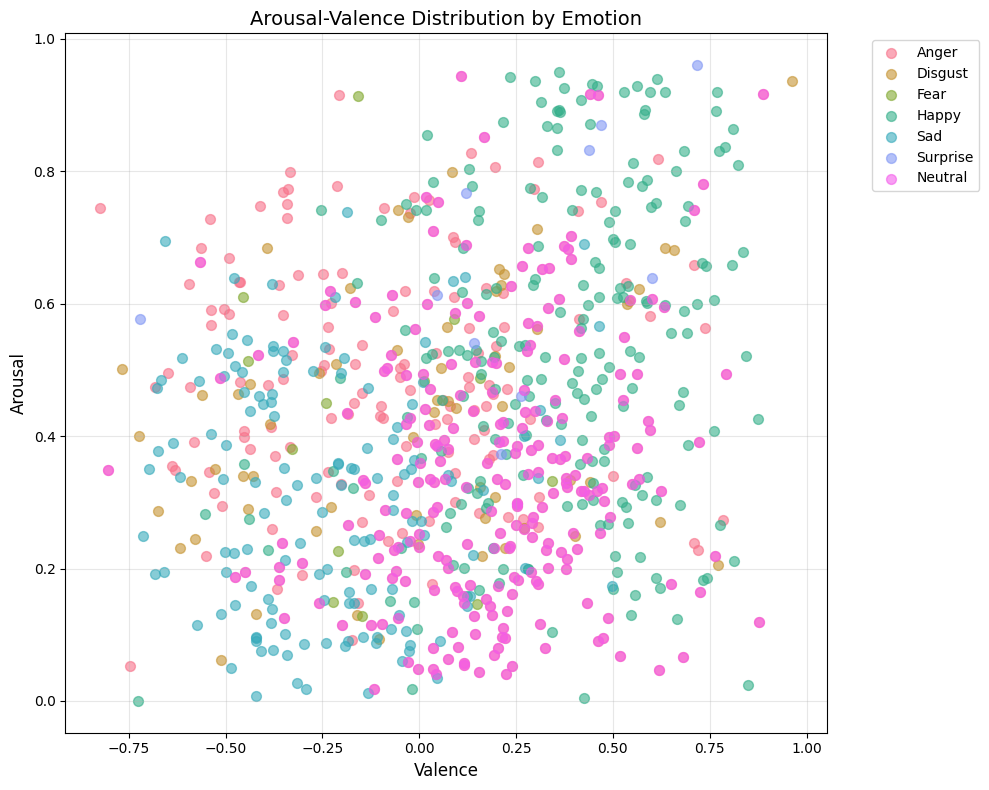

In [29]:
# 1. Arousal-Valence Scatter Plot by Emotion
print("Graph 1: Arousal-Valence Scatter Plot by Emotion")

plt.figure(figsize=(10, 8))

for i, emotion_name in enumerate(emotion_names_6):
    emotion_mask = np.argmax(all_emotions, axis=1) == i
    if np.sum(emotion_mask) > 0:
        plt.scatter(all_valences[emotion_mask], all_arousals[emotion_mask], 
                   c=[colors[i]], label=emotion_name, alpha=0.6, s=50)

# Add neutral emotions
neutral_mask = np.sum(all_emotions, axis=1) == 0
if np.sum(neutral_mask) > 0:
    plt.scatter(all_valences[neutral_mask], all_arousals[neutral_mask], 
               c=[colors[-1]], label='Neutral', alpha=0.6, s=50)

plt.xlabel('Valence', fontsize=12)
plt.ylabel('Arousal', fontsize=12)
plt.title('Arousal-Valence Distribution by Emotion', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Graph 2: Valence Distribution by Emotion


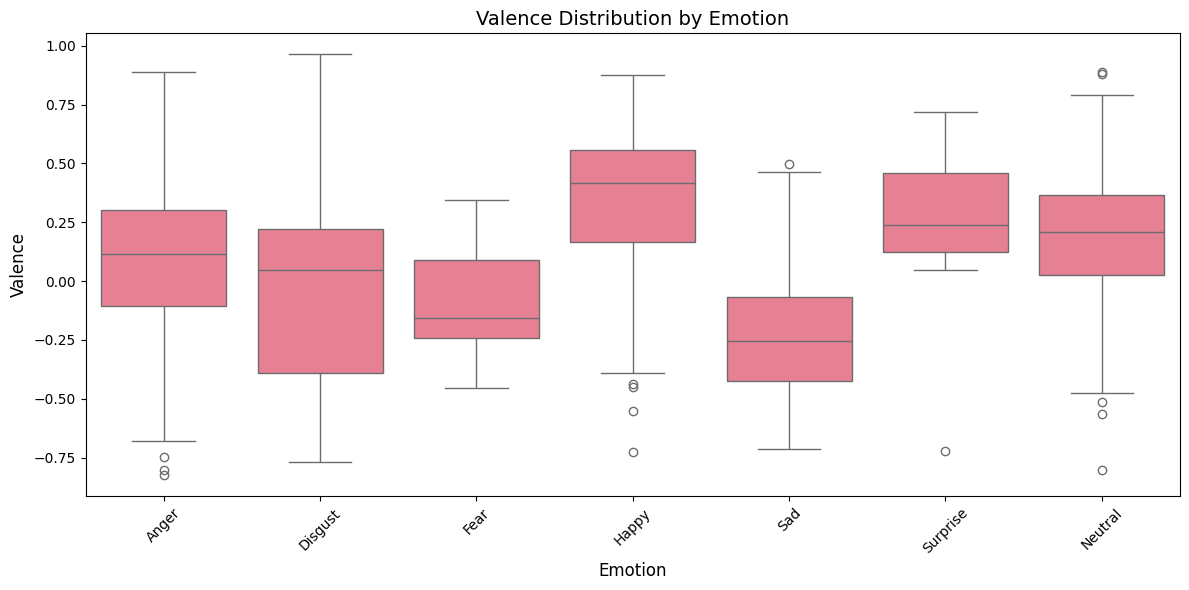

In [30]:
# 2. Valence Distribution Box Plot by Emotion
print("Graph 2: Valence Distribution by Emotion")

plt.figure(figsize=(12, 6))

valence_data = []
emotion_labels = []

for i, emotion_name in enumerate(emotion_names_6):
    emotion_mask = np.argmax(all_emotions, axis=1) == i
    if np.sum(emotion_mask) > 0:
        valence_data.extend(all_valences[emotion_mask])
        emotion_labels.extend([emotion_name] * np.sum(emotion_mask))

neutral_mask = np.sum(all_emotions, axis=1) == 0
if np.sum(neutral_mask) > 0:
    valence_data.extend(all_valences[neutral_mask])
    emotion_labels.extend(['Neutral'] * np.sum(neutral_mask))

df_valence = pd.DataFrame({'Emotion': emotion_labels, 'Valence': valence_data})
sns.boxplot(data=df_valence, x='Emotion', y='Valence')
plt.xticks(rotation=45)
plt.title('Valence Distribution by Emotion', fontsize=14)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Valence', fontsize=12)
plt.tight_layout()
plt.show()

Graph 3: Arousal Distribution by Emotion


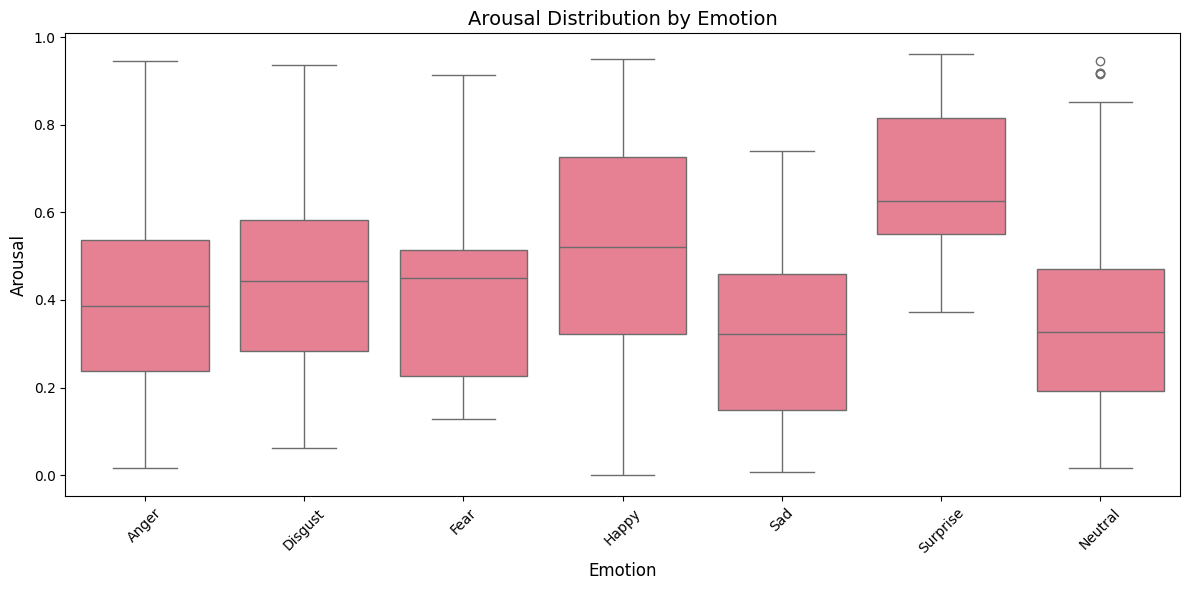

In [31]:
# 3. Arousal Distribution Box Plot by Emotion  
print("Graph 3: Arousal Distribution by Emotion")

plt.figure(figsize=(12, 6))

arousal_data = []
emotion_labels_arousal = []

for i, emotion_name in enumerate(emotion_names_6):
    emotion_mask = np.argmax(all_emotions, axis=1) == i
    if np.sum(emotion_mask) > 0:
        arousal_data.extend(all_arousals[emotion_mask])
        emotion_labels_arousal.extend([emotion_name] * np.sum(emotion_mask))

neutral_mask = np.sum(all_emotions, axis=1) == 0
if np.sum(neutral_mask) > 0:
    arousal_data.extend(all_arousals[neutral_mask])
    emotion_labels_arousal.extend(['Neutral'] * np.sum(neutral_mask))

df_arousal = pd.DataFrame({'Emotion': emotion_labels_arousal, 'Arousal': arousal_data})
sns.boxplot(data=df_arousal, x='Emotion', y='Arousal')
plt.xticks(rotation=45)
plt.title('Arousal Distribution by Emotion', fontsize=14)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Arousal', fontsize=12)
plt.tight_layout()
plt.show()

Graph 4: Mean Valence and Arousal Comparison


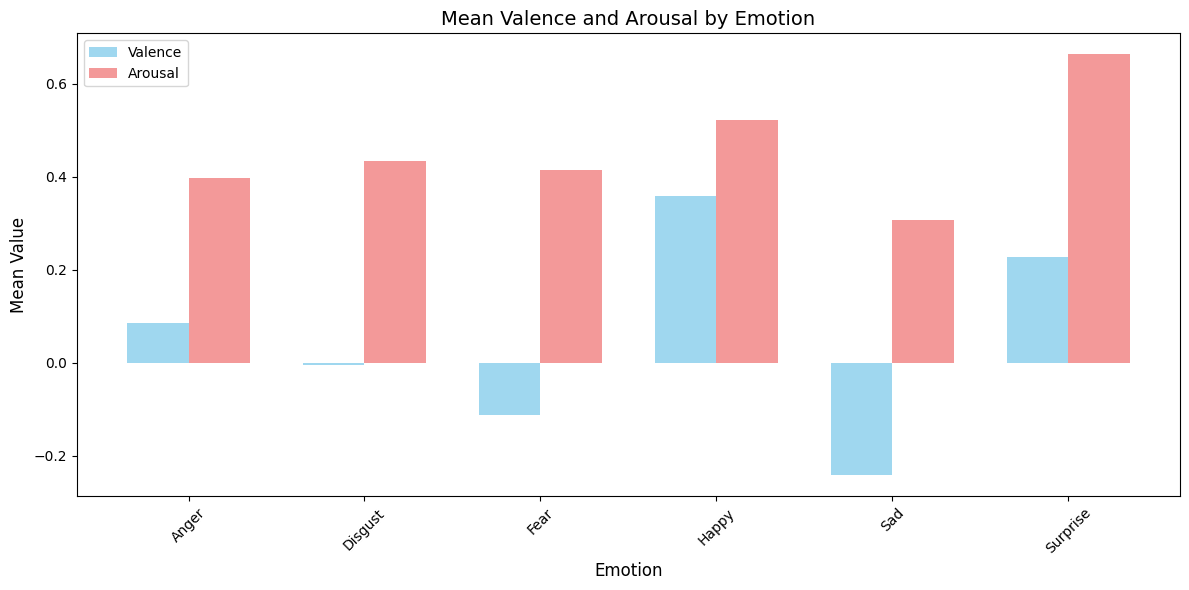

In [32]:
# 4. Mean Valence and Arousal Comparison Bar Chart
print("Graph 4: Mean Valence and Arousal Comparison")

plt.figure(figsize=(12, 6))

emotion_means_val = []
emotion_means_arousal = []
emotion_names_plot = []

for i, emotion_name in enumerate(emotion_names_6):
    emotion_mask = np.argmax(all_emotions, axis=1) == i
    if np.sum(emotion_mask) > 0:
        emotion_means_val.append(np.mean(all_valences[emotion_mask]))
        emotion_means_arousal.append(np.mean(all_arousals[emotion_mask]))
        emotion_names_plot.append(emotion_name)

x_pos = np.arange(len(emotion_names_plot))
width = 0.35

plt.bar(x_pos - width/2, emotion_means_val, width, label='Valence', alpha=0.8, color='skyblue')
plt.bar(x_pos + width/2, emotion_means_arousal, width, label='Arousal', alpha=0.8, color='lightcoral')
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Mean Value', fontsize=12)
plt.title('Mean Valence and Arousal by Emotion', fontsize=14)
plt.xticks(x_pos, emotion_names_plot, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Graph 5: Overall Valence Distribution


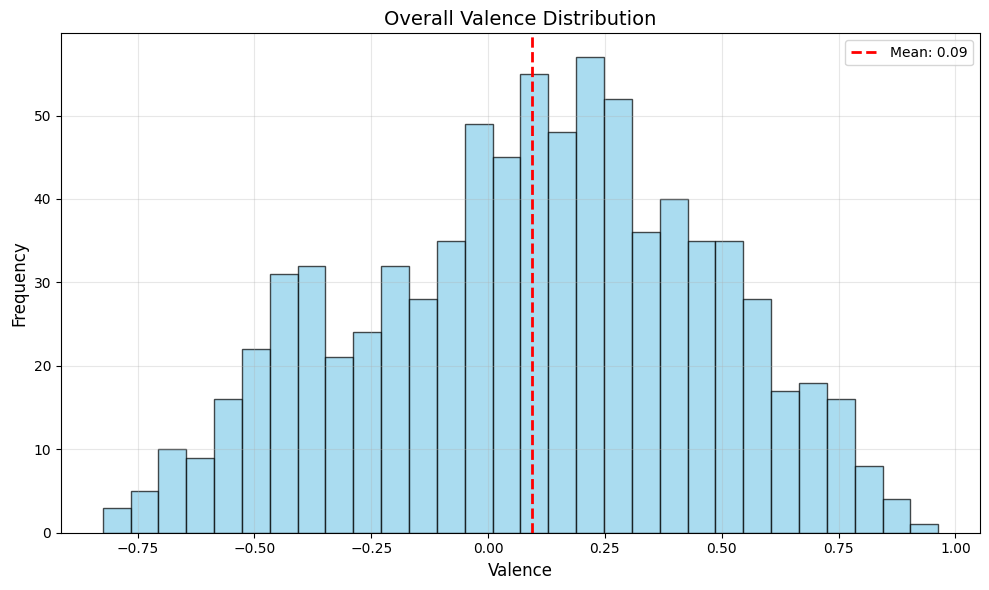

In [33]:
# 5. Overall Valence Distribution Histogram
print("Graph 5: Overall Valence Distribution")

plt.figure(figsize=(10, 6))
plt.hist(all_valences, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Valence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Overall Valence Distribution', fontsize=14)
plt.axvline(np.mean(all_valences), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(all_valences):.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Graph 6: Overall Arousal Distribution


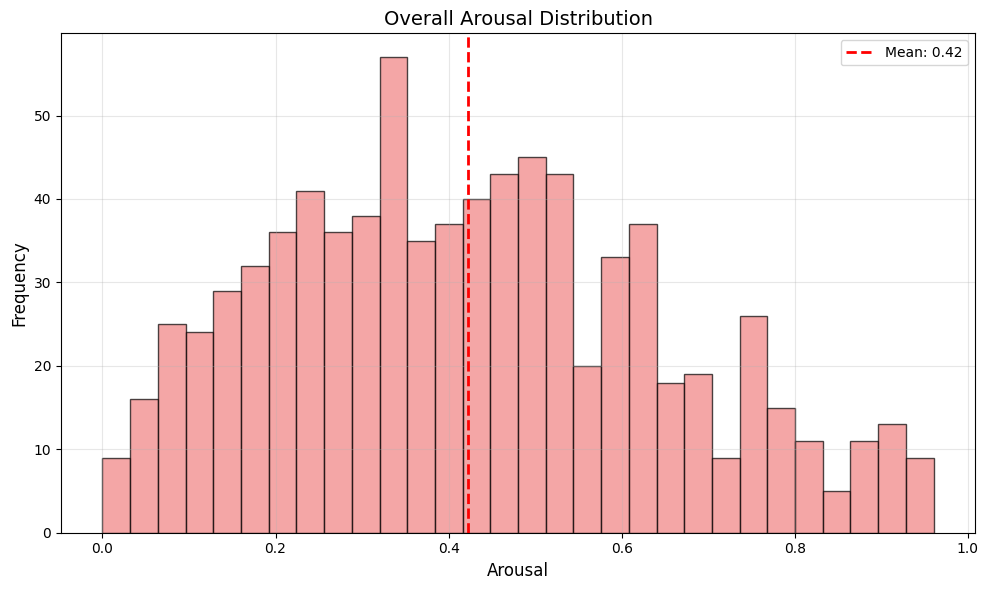

In [34]:
# 6. Overall Arousal Distribution Histogram
print("Graph 6: Overall Arousal Distribution")

plt.figure(figsize=(10, 6))
plt.hist(all_arousals, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Arousal', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Overall Arousal Distribution', fontsize=14)
plt.axvline(np.mean(all_arousals), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(all_arousals):.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Graph 7: Emotion Distribution in Dataset


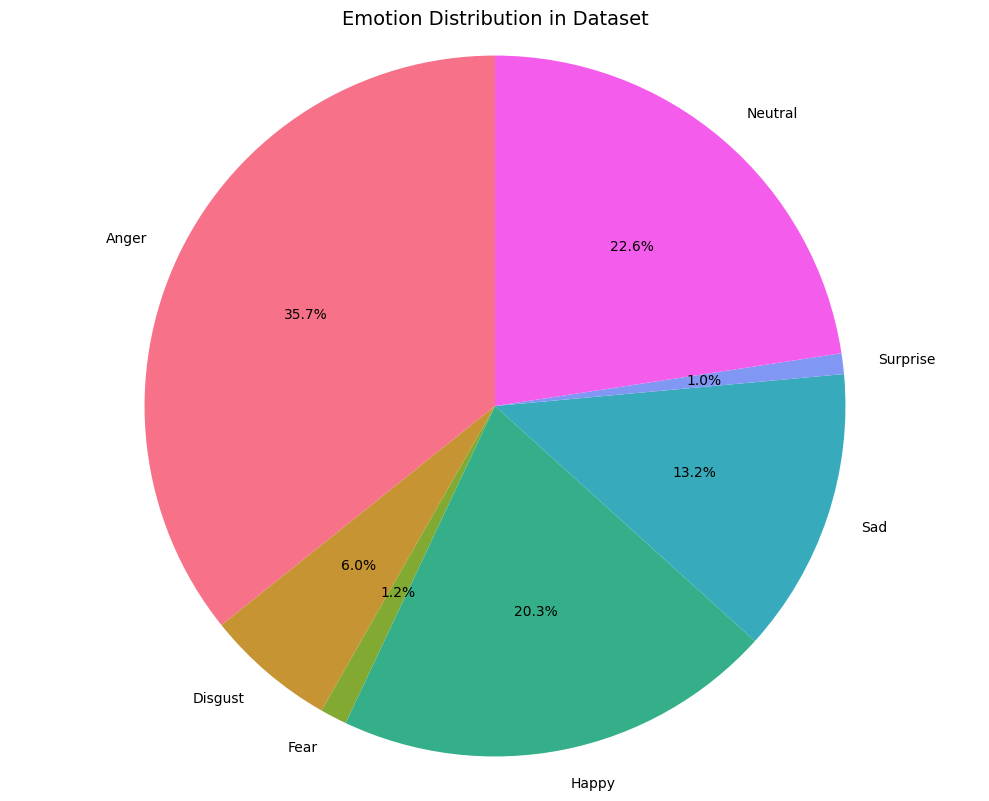

In [35]:
# 7. Emotion Frequency Distribution Pie Chart
print("Graph 7: Emotion Distribution in Dataset")

plt.figure(figsize=(10, 8))

emotion_counts = []
for i, emotion_name in enumerate(emotion_names_6):
    emotion_mask = np.argmax(all_emotions, axis=1) == i
    emotion_counts.append(np.sum(emotion_mask))

neutral_mask = np.sum(all_emotions, axis=1) == 0
emotion_counts.append(np.sum(neutral_mask))  # Add neutral count
emotion_names_with_neutral = emotion_names_6 + ['Neutral']

plt.pie(emotion_counts, labels=emotion_names_with_neutral, autopct='%1.1f%%', 
        startangle=90, colors=colors)
plt.title('Emotion Distribution in Dataset', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

Graph 8: Mean Arousal-Valence with Standard Deviation


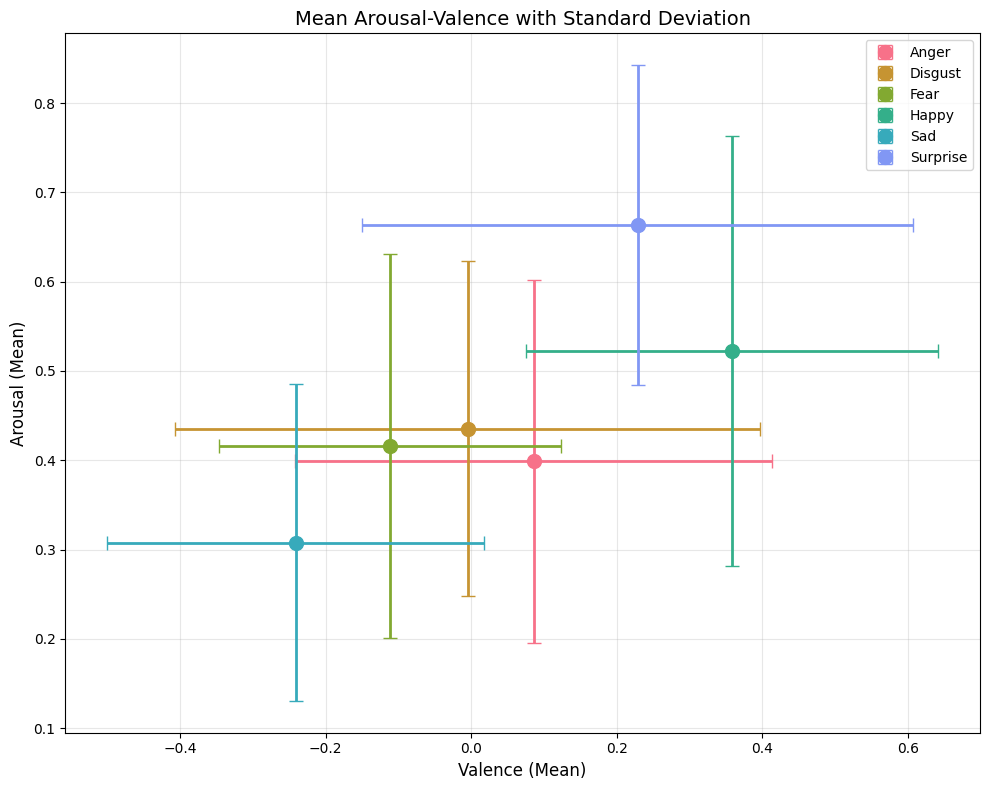

In [36]:
# 8. Mean Arousal-Valence Points with Error Bars
print("Graph 8: Mean Arousal-Valence with Standard Deviation")

plt.figure(figsize=(10, 8))

for i, emotion_name in enumerate(emotion_names_6):
    emotion_mask = np.argmax(all_emotions, axis=1) == i
    if np.sum(emotion_mask) > 0:
        val_mean = np.mean(all_valences[emotion_mask])
        val_std = np.std(all_valences[emotion_mask])
        arousal_mean = np.mean(all_arousals[emotion_mask])
        arousal_std = np.std(all_arousals[emotion_mask])
        
        plt.errorbar(val_mean, arousal_mean, xerr=val_std, yerr=arousal_std,
                    fmt='o', markersize=10, label=emotion_name, capsize=5, 
                    color=colors[i], linewidth=2)

plt.xlabel('Valence (Mean)', fontsize=12)
plt.ylabel('Arousal (Mean)', fontsize=12)
plt.title('Mean Arousal-Valence with Standard Deviation', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Graph 9: Emotion-Dimension Correlations


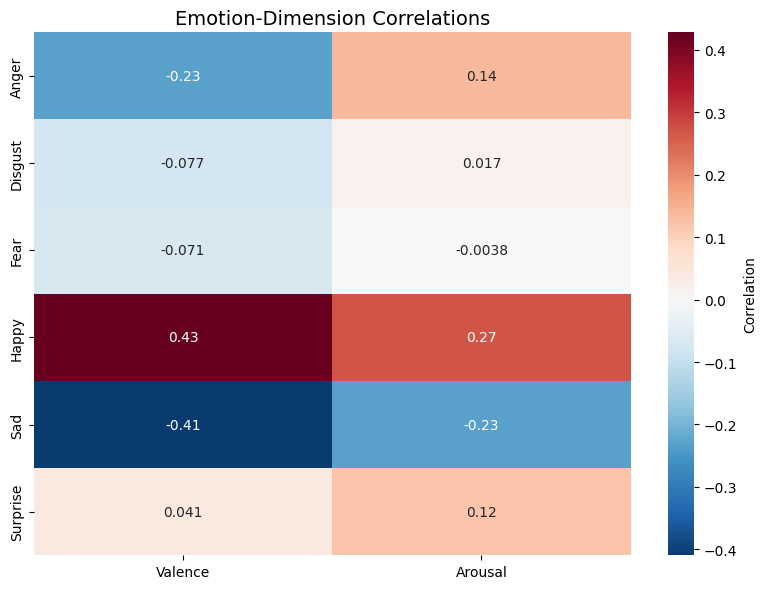


All individual visualizations complete!


In [37]:
# 9. Emotion-Dimension Correlation Heatmap
print("Graph 9: Emotion-Dimension Correlations")

plt.figure(figsize=(8, 6))

# Create correlation matrix between emotion intensities and valence/arousal
emotion_corr_data = []
for i in range(len(emotion_names_6)):
    emotion_intensities = all_emotions[:, i]
    val_corr = np.corrcoef(emotion_intensities, all_valences)[0, 1]
    arousal_corr = np.corrcoef(emotion_intensities, all_arousals)[0, 1]
    emotion_corr_data.append([val_corr, arousal_corr])

corr_matrix = np.array(emotion_corr_data)
sns.heatmap(corr_matrix, annot=True, xticklabels=['Valence', 'Arousal'], 
            yticklabels=emotion_names_6, cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Correlation'})
plt.title('Emotion-Dimension Correlations', fontsize=14)
plt.tight_layout()
plt.show()

print("\nAll individual visualizations complete!")